#WCGAN with RF as classifier with different data sizes

## Importing Libraries

In [ ]:
import os
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            confusion_matrix

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


## EDA

In [ ]:
df=pd.read_csv('./creditcard.csv')
df=df.drop('Time',axis=1)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

PCA Transformation: The description of the data says that all the features went through a PCA transformation (Except for time and amount).  
Scaling: Keep in mind that in order to implement a PCA transformation features need to be previously scaled.

In [ ]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# checking for duplicate values
print(f"Dataset has {df.duplicated().sum()} duplicate rows")
# dropping duplicate rows
df.drop_duplicates(inplace=True)

Dataset has 9144 duplicate rows


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275663 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      275663 non-null  float64
 1   V2      275663 non-null  float64
 2   V3      275663 non-null  float64
 3   V4      275663 non-null  float64
 4   V5      275663 non-null  float64
 5   V6      275663 non-null  float64
 6   V7      275663 non-null  float64
 7   V8      275663 non-null  float64
 8   V9      275663 non-null  float64
 9   V10     275663 non-null  float64
 10  V11     275663 non-null  float64
 11  V12     275663 non-null  float64
 12  V13     275663 non-null  float64
 13  V14     275663 non-null  float64
 14  V15     275663 non-null  float64
 15  V16     275663 non-null  float64
 16  V17     275663 non-null  float64
 17  V18     275663 non-null  float64
 18  V19     275663 non-null  float64
 19  V20     275663 non-null  float64
 20  V21     275663 non-null  float64
 21  V22     275663 

There is no null values

In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


<Axes: xlabel='Class', ylabel='count'>

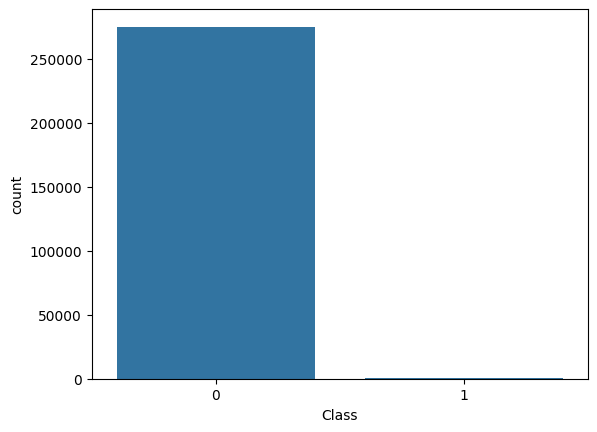

In [ ]:
sns.countplot(data=df,x='Class')

In [ ]:
df.drop('Class',axis=1).skew()

,0
V1,-3.273070
V2,-4.653486
V3,-2.216730
V4,0.681387
V5,-2.458790
V6,1.867576
V7,2.877722
V8,-8.292631
V9,0.550965
V10,1.242165


## Scaling

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Class', axis=1))
y = df['Class'].values
print(X.shape, y.shape)

(275663, 29) (275663,)


## Splitting the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Testing baseline model with original data

# WCGAN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam

def gradient_penalty(critic, real, fake, cond, gp_weight):
    # real, fake, cond are tf.Tensors of shape (batch, dim)
    batch_size = tf.shape(real)[0]
    alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0)
    diff = fake - real
    interp = real + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interp)
        pred = critic([interp, cond], training=True)
    grads = gp_tape.gradient(pred, interp)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-12)
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp_weight * gp

class CWGAN_GP:
    def __init__(self,
                 data_dim=29,
                 cond_dim=2,
                 latent_dim=100,
                 gp_weight=10.0,
                 n_critic=5,
                 batch_size=64):
        self.data_dim   = data_dim
        self.cond_dim   = cond_dim
        self.latent_dim = latent_dim
        self.gp_weight  = gp_weight
        self.n_critic   = n_critic
        self.batch_size = batch_size

        self._build_generator()
        self._build_critic()
        self.gen_opt  = Adam(1e-4, beta_1=0.0, beta_2=0.9)
        self.crit_opt = Adam(1e-4, beta_1=0.0, beta_2=0.9)

    def _build_generator(self):
        z = Input((self.latent_dim,), name='z')
        c = Input((self.cond_dim,), name='c')
        x = Concatenate()([z, c])
        for units in [256, 512, 512]:
            x = Dense(units)(x)
            x = LeakyReLU(0.2)(x)
            x = BatchNormalization()(x)
        out = Dense(self.data_dim, activation='linear')(x)
        self.generator = Model([z, c], out, name='generator')

    def _build_critic(self):
        x_in = Input((self.data_dim,), name='x')
        c_in = Input((self.cond_dim,), name='c')
        x = Concatenate()([x_in, c_in])
        for units in [512, 512, 256]:
            x = Dense(units)(x)
            x = LeakyReLU(0.2)(x)
        out = Dense(1)(x)
        self.critic = Model([x_in, c_in], out, name='critic')

    def train(self, real_data, real_cond, epochs=10000):
        # real_data: np.array shape (N, data_dim)
        # real_cond: tf.Tensor shape (N, cond_dim), one-hot
        N = real_data.shape[0]

        for epoch in range(epochs):
            # --- Train critic ---
            for _ in range(self.n_critic):

                idx      = np.random.randint(0, N, self.batch_size)
                real_x   = tf.convert_to_tensor(real_data[idx], dtype=tf.float32)
                cond_x   = tf.gather(real_cond, idx)


                z_noise  = tf.random.normal((self.batch_size, self.latent_dim))
                fake_idx = np.random.randint(0, N, self.batch_size)
                cond_z   = tf.gather(real_cond, fake_idx)
                fake_x   = self.generator([z_noise, cond_z], training=True)


                gp = gradient_penalty(self.critic, real_x, fake_x, cond_x, self.gp_weight)


                with tf.GradientTape() as tape:
                    crit_real = self.critic([real_x, cond_x], training=True)
                    crit_fake = self.critic([fake_x, cond_z], training=True)
                    loss_crit = tf.reduce_mean(crit_fake) - tf.reduce_mean(crit_real) + gp
                grads = tape.gradient(loss_crit, self.critic.trainable_variables)
                self.crit_opt.apply_gradients(zip(grads, self.critic.trainable_variables))

            # --- Train generator ---
            z_noise  = tf.random.normal((self.batch_size, self.latent_dim))
            fake_idx = np.random.randint(0, N, self.batch_size)
            cond_z   = tf.gather(real_cond, fake_idx)
            with tf.GradientTape() as tape:
                fake_x   = self.generator([z_noise, cond_z], training=True)
                crit_fake= self.critic([fake_x, cond_z], training=True)
                loss_gen = -tf.reduce_mean(crit_fake)
            grads = tape.gradient(loss_gen, self.generator.trainable_variables)
            self.gen_opt.apply_gradients(zip(grads, self.generator.trainable_variables))

            if epoch % 100 == 0:
                print(f"Epoch {epoch:5d} | Critic loss: {loss_crit:.4f} | Gen loss: {loss_gen:.4f}")


In [ ]:
# 1) Instantiate
cwgan_gp = CWGAN_GP(
    data_dim   = X_train.shape[1],
    cond_dim   = 2,                # e.g. [fraud, non-fraud]
    latent_dim = 100,
    gp_weight  = 10.0,
    n_critic   = 5,
    batch_size = 64
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from tqdm import tqdm
import numpy as np
import tensorflow as tf

def experiment_1_scaling_gan(GAN_class, X_train, y_train, X_test, y_test, scaler, epochs=300, latent_dim=32):


    fraud_data = X_train[y_train == 1]
    nonfraud_data = X_train[y_train == 0]

    # Percentages to test
    sizes = [0.01, 0.05, 0.1, 0.5, 1.0]
    results = []

    for frac in tqdm(sizes, desc="Experiment 1 Loop"):
        sample_size = int(len(fraud_data) * frac)
        fraud_subset = fraud_data[:sample_size]


        combined_X = np.vstack([fraud_subset, nonfraud_data])
        combined_y = np.vstack([
            np.ones((sample_size, 1)),
            np.zeros((len(nonfraud_data), 1))
        ])


        combined_y_one_hot = tf.one_hot(tf.cast(combined_y.ravel(), tf.int32), depth=2)


        gan = GAN_class(latent_dim=latent_dim)
        gan.train(combined_X, combined_y_one_hot, epochs=epochs)

        noise = np.random.normal(0, 1, (25000, latent_dim))
        # Generate only fraud samples (conditional input for fraud is [0, 1])
        fraud_cond = tf.constant([[0.0, 1.0]] * 25000, dtype=tf.float32)
        gen_samples = gan.generator.predict([noise, fraud_cond], verbose=0)


        # Combine real+synthetic fraud for classifier training
        aug_X = np.vstack([X_train, gen_samples])
        aug_y = np.vstack([y_train.reshape(-1, 1), np.ones((25000, 1))]).ravel()


        # Train classifier on augmented data
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(aug_X, aug_y)

        # Evaluate on original test set
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        # Metrics
        roc = roc_auc_score(y_test, y_prob)
        pr = average_precision_score(y_test, y_prob)
        f1 = f1_score(y_test, y_pred)

        results.append((int(frac*100), roc, pr, f1))

    return results

In [ ]:
def plot_experiment_1(results):
    import matplotlib.pyplot as plt
    x = [r[0] for r in results]
    roc = [r[1] for r in results]
    pr = [r[2] for r in results]
    f1 = [r[3] for r in results]

    plt.figure(figsize=(10, 6))
    plt.plot(x, roc, label="ROC-AUC", marker='o')
    plt.plot(x, pr, label="PR-AUC", marker='s')
    plt.plot(x, f1, label="F1-score", marker='^')
    plt.xlabel("Fraud Training Set Size (%)")
    plt.ylabel("Score")
    plt.title("Experiment 1: Model Performance vs GAN Training Size")
    plt.grid(True)
    plt.legend()
    plt.show()


Experiment 1 Loop:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch     0 | Critic loss: 5.8082 | Gen loss: 0.7706
Epoch   100 | Critic loss: 1000.0027 | Gen loss: 9.0019
Epoch   200 | Critic loss: 180149.3281 | Gen loss: 21.1575


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.

Experiment 1 Loop:  20%|██        | 1/5 [13:11<52:45, 791.38s/it]

Epoch     0 | Critic loss: 6.1009 | Gen loss: 0.5567
Epoch   100 | Critic loss: 1027.5773 | Gen loss: 6.7432
Epoch   200 | Critic loss: 127646.8438 | Gen loss: 17.3449


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.

Experiment 1 Loop:  40%|████      | 2/5 [26:45<40:13, 804.53s/it]

Epoch     0 | Critic loss: 5.6891 | Gen loss: 0.5860
Epoch   100 | Critic loss: 877.8315 | Gen loss: 9.0807
Epoch   200 | Critic loss: 133085.1250 | Gen loss: 35.1817


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.

Experiment 1 Loop:  60%|██████    | 3/5 [39:14<25:58, 779.17s/it]

Epoch     0 | Critic loss: 5.5815 | Gen loss: 0.6975
Epoch   100 | Critic loss: 983.2957 | Gen loss: 4.6830
Epoch   200 | Critic loss: 253520.4375 | Gen loss: 19.7992


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.

Experiment 1 Loop:  80%|████████  | 4/5 [52:44<13:11, 791.69s/it]

Epoch     0 | Critic loss: 6.6766 | Gen loss: 0.5068
Epoch   100 | Critic loss: 548.9078 | Gen loss: 6.1196
Epoch   200 | Critic loss: 92289.0469 | Gen loss: 21.9226


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.

Experiment 1 Loop: 100%|██████████| 5/5 [1:05:45<00:00, 789.14s/it]


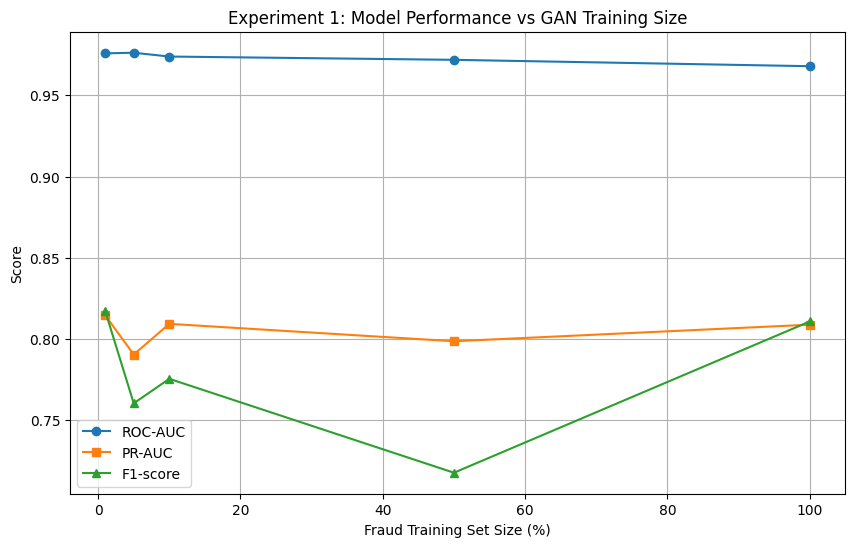

In [ ]:
results = experiment_1_scaling_gan(CWGAN_GP, X_train, y_train, X_test, y_test, scaler)
plot_experiment_1(results)

Stable ROC-AUC (~0.96): Strong ranking ability throughout.

Moderate PR-AUC (~0.80–0.82): Consistent, but not as high as CTGAN or VAE-GAN, meaning precision-recall balance is weaker.

Volatile F1-score: Mid-training sizes cause recall drops, but performance stabilizes at higher sizes.

Overall: WCGAN + RF is robust in ROC-AUC, but less consistent in recall (F1-score). It works best with larger fraud training sets, where recall and F1 recover.

Note- ChatGPT used for understanding results and on error in the main wcgan model based on the gradient penalty and how it used.


Referneces-[A hybrid deep learning approach with generative adversarial network for credit card fraud detection](https://doi.org/10.3390/technologies12100186), [Improving detection of credit card fraudulent transactions using generative adversarial networks](https://arxiv.org/abs/1907.03355),https://www.kaggle.com/code/shiratorizawa/wcgan, https://www.kaggle.com/code/gauravduttakiit/cc-fraud-detection-gan-random-forest-classifier/data